# Car Detection

In this notebook, we will explore the process of detecting and tracking cars in a video stream using OpenCV. Our primary objectives are to extract the video's background, identify moving cars, and count the number of cars passing through the video.

For this analysis, we will utilize three distinct clips of highway traffic videos. These clips are selected to demonstrate varying traffic densities and conditions, providing a comprehensive assessment of our car detection and tracking methodologies.

## Manipulating Video Streams

To begin, we will import the necessary libraries and load the video clips for analysis. 

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import sys
import numpy as np
from ipywidgets import interact, IntSlider, fixed

# Define video paths
LIGHT_TRAFFIC_VID = './videos/highway3.mp4'
MEDIUM_TRAFFIC_VID = './videos/highway.avi'
HEAVY_TRAFFIC_VID = './videos/highway2.mp4'

# Define key codes
ESC_KEY = 27
Q_KEY = ord('q')

### Displaying Video Clips

Using the `cv2.VideoCapture` function, we can load the video clips and display them using the `cv2.imshow` function. This function will display the video clips in a separate window, allowing us to visualize the traffic conditions and the cars moving through the highway.

In [2]:
# Open the video file
cap = cv.VideoCapture(HEAVY_TRAFFIC_VID)

if not cap.isOpened():
    print("Capture opening has failed; exiting.")
    sys.exit()

# Creating windows to display the original video
cv.namedWindow("Original video", cv.WINDOW_AUTOSIZE)

try:
    while True:
        ret, im = cap.read()
        if not ret:
            break

        cv.imshow("Original video", im)

        key = cv.pollKey()
        if key in [ESC_KEY, Q_KEY]:
            break
finally:
    cap.release()
    cv.destroyAllWindows()


The video is displayed by sequentially rendering each frame as quickly as possible without adhering to a specific frame rate. Unlike standard video players that maintain a consistent playback speed by displaying frames at regular intervals (e.g., 30 frames per second), this approach allows the display speed to vary based on the computer's processing capabilities. As a result, the video playback speed may fluctuate depending on the performance of the system running the notebook.

### Extracting Video Information

Considering the video is $ t $ seconds long and contains $ n $ frames per second, the total number of frames $ N $ in the video is given by 

$$ N = t * n $$

By extracting the video's frame rate and dimensions, we can calculate the total number of frames in the video and display the video's duration in seconds.

In [3]:
# Define a dictionary of video names and their paths
videos = {
    'Light Traffic': LIGHT_TRAFFIC_VID,
    'Medium Traffic': MEDIUM_TRAFFIC_VID,
    'Heavy Traffic': HEAVY_TRAFFIC_VID
}

# Iterate over each video and print its metrics
for name, path in videos.items():
    cap = cv.VideoCapture(path)
    
    if not cap.isOpened():
        print(f"Capture opening for {name} has failed; exiting.")
        sys.exit()
    
    # Get total number of frames
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    
    # Get frame rate (frames per second)
    fps = cap.get(cv.CAP_PROP_FPS)
    
    # Calculate duration in seconds
    duration = frame_count / fps
    
    # Get video resolution
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    # Print the metrics
    print(f"{name} Video:")
    print(f"Total number of frames: {frame_count}")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Resolution: {width}x{height}\n")
    
    # Release the video capture
    cap.release()

Light Traffic Video:
Total number of frames: 1673
Duration: 111.53 seconds
Resolution: 320x240

Medium Traffic Video:
Total number of frames: 614
Duration: 20.47 seconds
Resolution: 384x288

Heavy Traffic Video:
Total number of frames: 1406
Duration: 46.91 seconds
Resolution: 640x360



### Storing Video Frames

In order to work more efficiently with the video frames, we will play the video once to extract all the frames and store them in a list. This approach allows us to access the video frames without needing to replay the video each time we need to access a specific frame.

In [4]:
cap_light = cv.VideoCapture(LIGHT_TRAFFIC_VID)
cap_medium = cv.VideoCapture(MEDIUM_TRAFFIC_VID)
cap_heavy = cv.VideoCapture(HEAVY_TRAFFIC_VID)

# Initialize lists to store frames
heavy_frames = []
medium_frames = []
light_frames = []

# Function to read frames from a VideoCapture and store in a list
def read_frames(cap, frame_list):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_list.append(frame)
    cap.release()

# Read frames from light traffic video
read_frames(cap_light, light_frames)

# Read frames from light traffic video
read_frames(cap_medium, medium_frames)

# Read frames from heavy traffic video
read_frames(cap_heavy, heavy_frames)

print(f"Light traffic frames stored: {len(light_frames)}")
print(f"Medium traffic frames stored: {len(medium_frames)}")
print(f"Heavy traffic frames stored: {len(heavy_frames)}")

Light traffic frames stored: 1673
Medium traffic frames stored: 614
Heavy traffic frames stored: 1370


When printing the number of frames for each video, we observe that the heavy traffic video has a higher frame count in its metadata (`cv.CAP_PROP_FRAME_COUNT`) compared to the actual number of extracted frames. This discrepancy occurs because the extraction process only counts successfully extracted frames. If the video contains corrupted frames or frames that cannot be extracted, the total number of extracted frames will be less than the metadata count.

### Converting Video Frames to Grayscale

To simplify the car detection process, we will convert the video frames to grayscale. This conversion reduces the complexity of the image data, making it easier to identify moving objects and track them across frames.

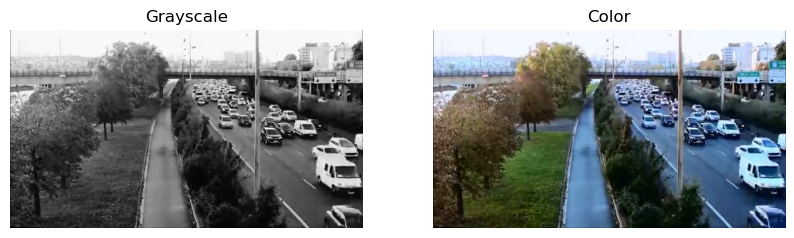

In [5]:
# Convert frames to grayscale
heavy_gray_frames = [cv.cvtColor(frame, cv.COLOR_BGR2GRAY) for frame in heavy_frames]
medium_gray_frames = [cv.cvtColor(frame, cv.COLOR_BGR2GRAY) for frame in medium_frames]
light_gray_frames = [cv.cvtColor(frame, cv.COLOR_BGR2GRAY) for frame in light_frames]

# Play the heavy traffic video in grayscale
cv.namedWindow("Heavy Traffic Grayscale", cv.WINDOW_AUTOSIZE)

try:
    for frame in heavy_gray_frames:
        cv.imshow("Heavy Traffic Grayscale", frame)
        key = cv.pollKey()
        if key in [ESC_KEY, Q_KEY]:
            break
finally:
    cv.destroyAllWindows()


# Get the grayscale and color frames
gray_frame = heavy_gray_frames[0]
color_frame = heavy_frames[0]

# Convert BGR to RGB for correct color display
color_frame_rgb = cv.cvtColor(color_frame, cv.COLOR_BGR2RGB)

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(gray_frame, cmap='gray')
axes[0].set_title('Grayscale')
axes[0].axis('off')

axes[1].imshow(color_frame_rgb)
axes[1].set_title('Color')
axes[1].axis('off')
plt.show()

### Extracting the Background

To detect moving cars, it is essential to extract the video's background. This involves identifying and isolating the stationary elements within the video, such as roads, trees, and buildings, and removing them from the frames.

The background of a video is characterized by pixels that remain constant across frames. By averaging the pixel values of each frame, we can create a background image that effectively represents these stationary elements.

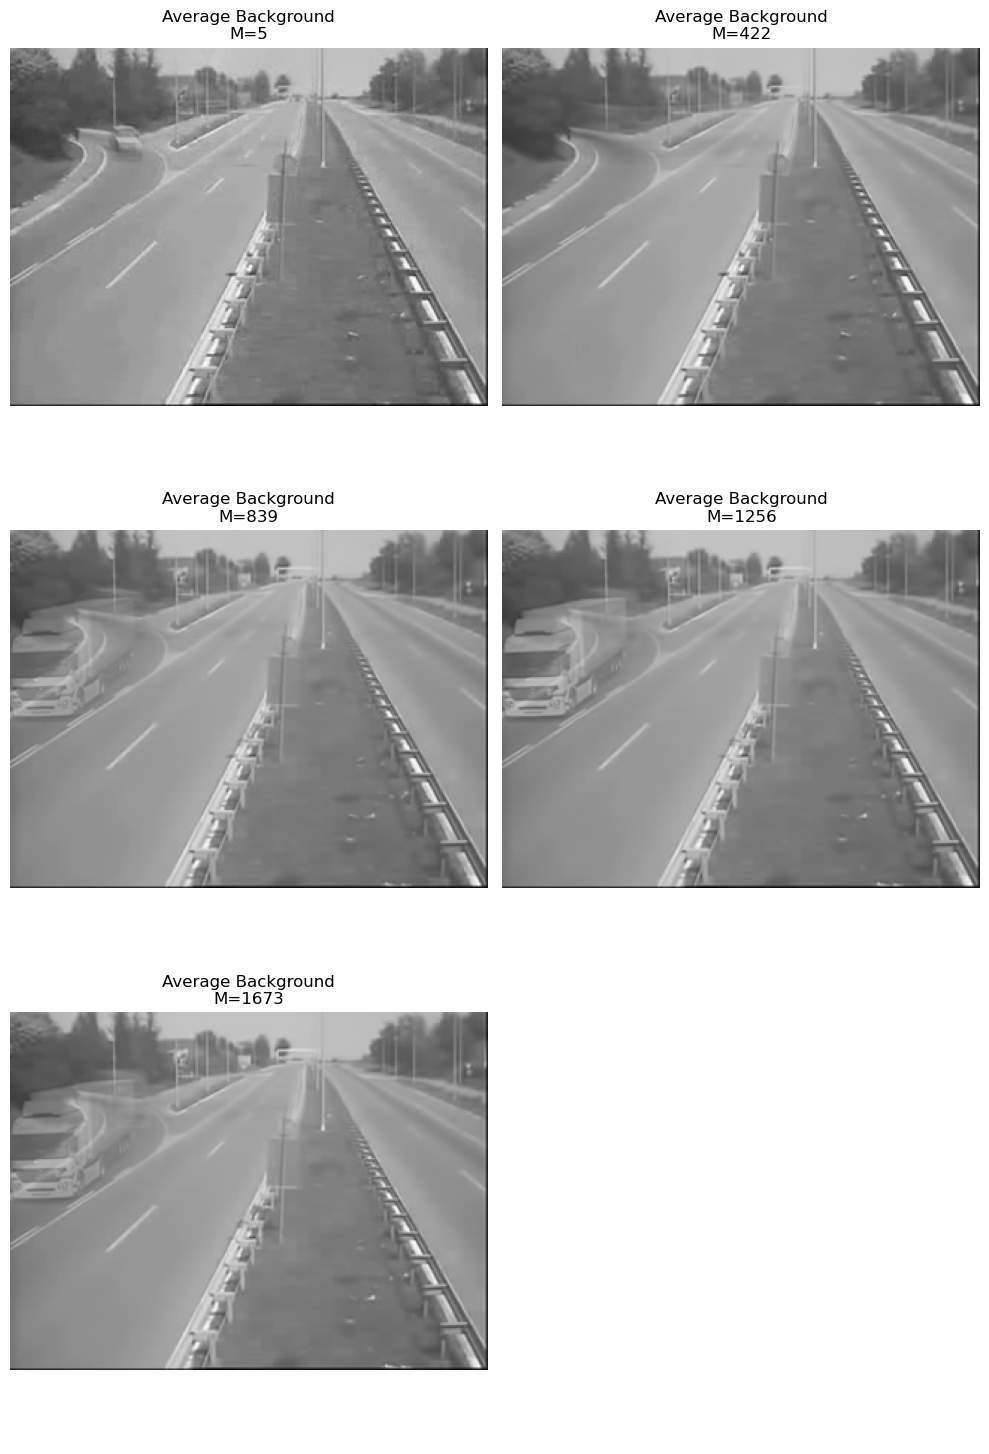

In [6]:
def compute_average_background(frames, M):
    """
    Compute the average background by averaging M consecutive frames.

    Args:
        frames (list of numpy arrays): List of grayscale frames.
        M (int): Number of consecutive frames to average.

    Returns:
        numpy array: Averaged background image.
    """
    if M > len(frames):
        raise ValueError("M is larger than the number of available frames.")

    # Stack M frames and compute the mean
    stacked_frames = np.stack(frames[:M], axis=0)
    average_background = np.mean(stacked_frames, axis=0).astype(np.uint8)
    return average_background

# Illustrate the calculation of the average for different M values
M_values = np.linspace(5, len(light_gray_frames), 5, dtype=int)
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for ax, M in zip(axes.ravel(), M_values):
    avg_bg = compute_average_background(light_gray_frames, M)
    ax.imshow(avg_bg, cmap='gray')
    ax.set_title(f'Average Background\nM={M}')
    ax.axis('off')
for ax in axes.ravel()[len(M_values):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


Selecting the appropriate $M$ (the number of frames to average) is challenging, as it depends on the video's characteristics and the desired level of detail in the background image. A higher $M$ value yields a smoother background but may not accurately represent the stationary elements in the video. Conversely, a lower $M$ value captures more details but can introduce noise and artifacts into the background image. To balance these factors, we experiment with various $M$ values to visually determine which value offers the best background representation.

In the light traffic video, we find that $M = 30$ provides a clear background representation, while $M = 400$ is more suitable for medium and heavy traffic videos. These values are chosen based on the visual clarity of the background image and the level of detail preserved in the stationary elements.

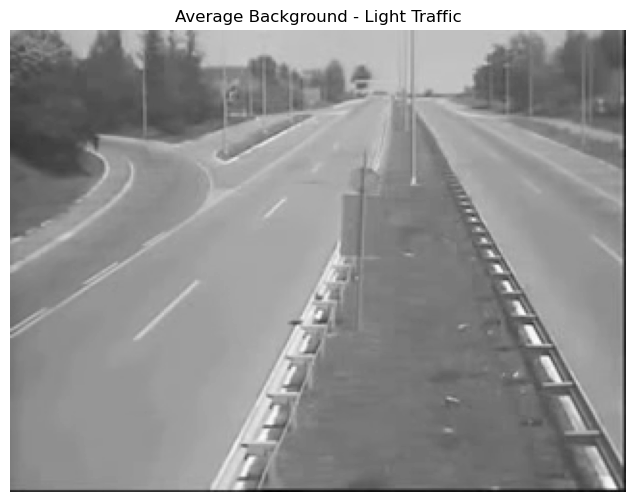

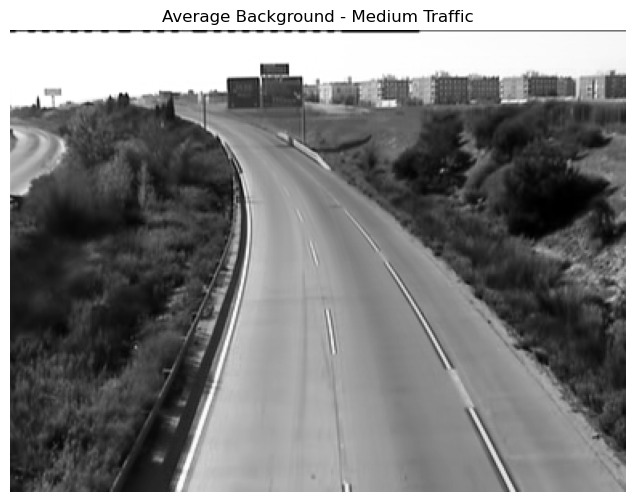

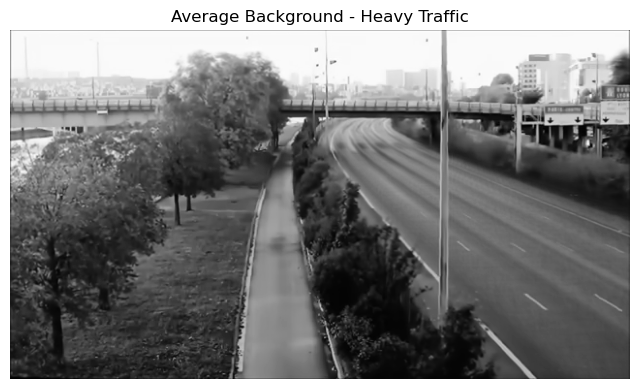

In [7]:
# Compute average backgrounds for each traffic category
average_background_light = compute_average_background(light_gray_frames, M=30)
average_background_medium = compute_average_background(medium_gray_frames, M=400)
average_background_heavy = compute_average_background(heavy_gray_frames, M=400)

# Store the average backgrounds in a dictionary
average_backgrounds = {
    'Light Traffic': average_background_light,
    'Medium Traffic': average_background_medium,
    'Heavy Traffic': average_background_heavy
}

for name, bg in average_backgrounds.items():
    plt.figure(figsize=(8, 6))
    plt.imshow(bg, cmap='gray')
    plt.title(f'Average Background - {name}')
    plt.axis('off')
    plt.show()

### Extracting the Road from the Video

In this step, we aim to isolate the road within each frame of the video sequence. This isolation will enable us to focus on the area of interest where cars are moving. To achieve this, we will create a mask that retains only the pixels corresponding to the road. Applying this mask to the video frames will effectively extract the road area for further analysis.

The process is divided into different steps:

1. **Gaussian Blurring**: The goal is to reduce noise and detail in the image, making it easier to identify the road area. It will minimize the impact of small variations in pixel values that are not relevant to the road detection process. We can adjust the kernel size to control the blurring effect and the level of detail retained in the image (e.g., a larger kernel size results in more blurring).

2. **Thresholding**: By converting the image to binary form, we can separate the road area from the rest of the frame. This step involves setting a threshold value that distinguishes between the road and other elements in the image. In our case, since the sky is brighter than the road, and the vegetation is darker than the road, we use a dual thresholding approach to capture both scenarios. We can adjust the threshold values to refine the mask and ensure that the road area is correctly identified.

3. **Morphological Operations**: These operations help refine the mask by removing noise and filling gaps in the road area. We can use morphological transformations such as opening and closing to improve the mask's accuracy and ensure that the road area is correctly identified.

Since the process of tuning the different parameters (e.g., kernel size, threshold value) is specific to each image, we are using ipywidgets to interactively adjust these parameters and observe their impact on the road detection process.

In [8]:
def create_mask(background, blur_kernel_size, lower_thresh, upper_thresh, 
                morph_open_size, morph_open_iterations, morph_close_size, morph_close_iterations, return_mask=False):
    """
    Creates a road mask from a background image using dual thresholding and optional morphological operations.

    Args:
        background (numpy.ndarray): The input grayscale background image.
        blur_kernel_size (int): The kernel size for Gaussian blurring. The effective kernel used is the next odd integer.
        lower_thresh (int): The lower intensity threshold for dual thresholding.
        upper_thresh (int): The upper intensity threshold for dual thresholding.
        morph_open_size (int): The kernel size for the morphological opening operation. Used to remove small noise.
        morph_open_iterations (int): The number of iterations to perform the morphological opening.
        morph_close_size (int): The kernel size for the morphological closing operation. Used to close small holes.
        morph_close_iterations (int): The number of iterations to perform the morphological closing.
        return_mask (bool, optional): If True, the function returns the computed mask instead of displaying the images.
                                      Defaults to False.

    Returns:
        numpy.ndarray or None: Returns the mask if 'return_mask' is True; otherwise, displays the images and returns None.
    """
    # Ensure odd kernel size for blur
    blur_kernel = max(1, blur_kernel_size // 2 * 2 + 1)
    
    # Blur to reduce noise
    blurred = cv.GaussianBlur(background, (blur_kernel, blur_kernel), 0)
    
    # Dual thresholding
    mask = cv.inRange(blurred, lower_thresh, upper_thresh)
    
    # Apply opening if a valid kernel size and iterations are set
    if morph_open_size > 0 and morph_open_iterations > 0:
        morph_open = max(1, morph_open_size // 2 * 2 + 1)
        kernel_open = cv.getStructuringElement(cv.MORPH_ELLIPSE, (morph_open, morph_open))
        mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel_open, iterations=morph_open_iterations)
    
    # Apply closing if a valid kernel size and iterations are set
    if morph_close_size > 0 and morph_close_iterations > 0:
        morph_close = max(1, morph_close_size // 2 * 2 + 1)
        kernel_close = cv.getStructuringElement(cv.MORPH_ELLIPSE, (morph_close, morph_close))
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel_close, iterations=morph_close_iterations)
    
    if return_mask:
        return mask
    
    # Visualization: Display the blurred image, the mask, and the extracted road based on the mask.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(blurred, cmap='gray')
    axes[0].set_title('Blurred')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[2].imshow(cv.bitwise_and(background, background, mask=mask), cmap='gray')
    axes[2].set_title('Extracted Road')
    for ax in axes:
        ax.axis('off')
    plt.show()


def mask_tuner(background_name):
    """
    Provides an interactive widget to tune the parameters for creating a road mask.

    Args:
        background_name (str): A key to select the background image. Expected values are "Heavy", "Medium", or "Light".

    Returns:
        None. Displays an interactive widget for tuning the mask creation parameters.
    """
    backgrounds = {
        "Heavy": average_background_heavy,
        "Medium": average_background_medium,
        "Light": average_background_light
    }
    
    interact(
        create_mask,
        background=fixed(backgrounds[background_name]),
        blur_kernel_size=IntSlider(value=1, min=1, max=101, step=2, description='Blur Kernel:'),
        lower_thresh=IntSlider(value=0, min=0, max=255, description='Lower Threshold:'),
        upper_thresh=IntSlider(value=255, min=0, max=255, description='Upper Threshold:'),
        morph_open_size=IntSlider(value=1, min=1, max=51, step=2, description='Open Kernel:'),
        morph_open_iterations=IntSlider(value=0, min=0, max=20, description='Open Iterations:'),
        morph_close_size=IntSlider(value=1, min=1, max=51, step=2, description='Close Kernel:'),
        morph_close_iterations=IntSlider(value=0, min=0, max=20, description='Close Iterations:'),
        return_mask=fixed(False)
    )

# To launch the tuner for a "Medium" background, call:
mask_tuner("Medium")

interactive(children=(IntSlider(value=1, description='Blur Kernel:', max=101, min=1, step=2), IntSlider(value=…

Now that we have fine-tuned the parameters for road detection, we can apply the mask to each frame of the videos and see how it looks.

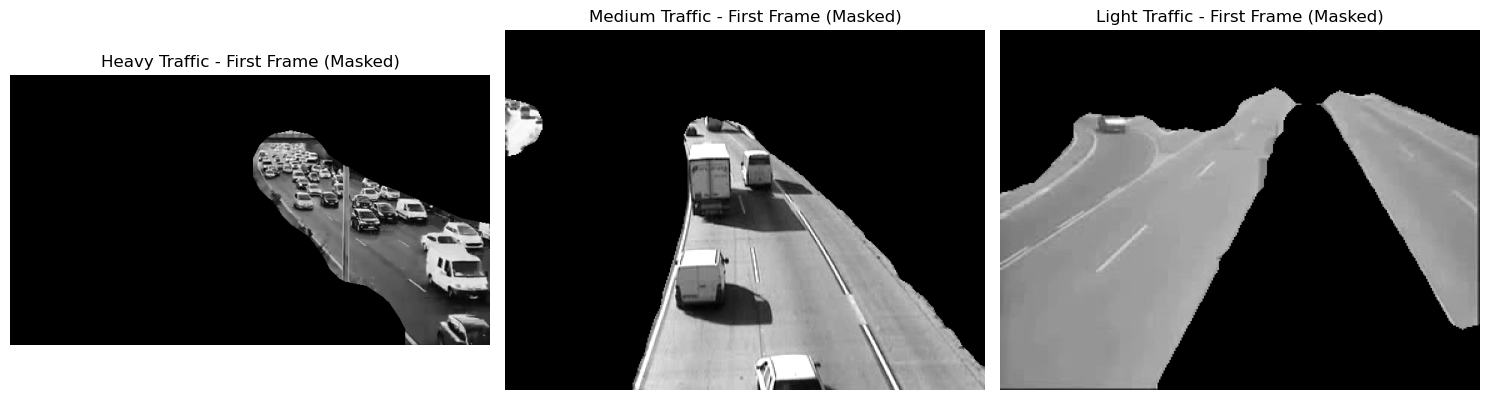

In [9]:
# Create masks for each traffic category
mask_heavy = create_mask(
    background=average_background_heavy,
    blur_kernel_size=61,
    lower_thresh=76,
    upper_thresh=154,
    morph_open_size=25,
    morph_open_iterations=4,
    morph_close_size=23,
    morph_close_iterations=7,
    return_mask=True,
)

mask_medium = create_mask(
    background=average_background_medium,
    blur_kernel_size=17,
    lower_thresh=112,
    upper_thresh=198,
    morph_open_size=19,
    morph_open_iterations=2,
    morph_close_size=0,
    morph_close_iterations=0,
    return_mask=True,
)

mask_light = create_mask(
    background=average_background_light,
    blur_kernel_size=3,
    lower_thresh=135,
    upper_thresh=186,
    morph_open_size=7,
    morph_open_iterations=3,
    morph_close_size=17,
    morph_close_iterations=2,
    return_mask=True,
)

def play_masked_video(window_name, gray_frames, mask):
    """
    Play a video with a mask applied to each frame.

    Args:
        window_name (str): The name of the window.
        gray_frames (list of numpy arrays): List of grayscale frames.
        mask (numpy array): The mask to apply to each frame.
    """
    cv.namedWindow(window_name, cv.WINDOW_AUTOSIZE)
    try:
        for frame in gray_frames:
            masked_frame = cv.bitwise_and(frame, frame, mask=mask)
            cv.imshow(window_name, masked_frame)
            if cv.waitKey(30) in [ESC_KEY, Q_KEY]:
                break
    finally:
        cv.destroyAllWindows()

# Play the videos with the masks applied
for name, frames, mask in [
    ("Heavy Traffic Grayscale", heavy_gray_frames, mask_heavy),
    ("Medium Traffic Grayscale", medium_gray_frames, mask_medium),
    ("Light Traffic Grayscale",  light_gray_frames, mask_light)
]:
    play_masked_video(name, frames, mask)

# Apply mask on first frame of each video
masked_heavy = cv.bitwise_and(heavy_gray_frames[0], heavy_gray_frames[0], mask=mask_heavy)
masked_medium = cv.bitwise_and(medium_gray_frames[0], medium_gray_frames[0], mask=mask_medium)
masked_light = cv.bitwise_and(light_gray_frames[0], light_gray_frames[0], mask=mask_light)

# Plot the masked first frames
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(masked_heavy, cmap='gray')
axes[0].set_title('Heavy Traffic - First Frame (Masked)')
axes[0].axis('off')

axes[1].imshow(masked_medium, cmap='gray')
axes[1].set_title('Medium Traffic - First Frame (Masked)')
axes[1].axis('off')

axes[2].imshow(masked_light, cmap='gray')
axes[2].set_title('Light Traffic - First Frame (Masked)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


The road detection process is correctly isolating the road area in each frame, allowing us to focus on the region where cars are moving. However, the process is not perfect, as it crops out some parts of the road. A better approach would involve manually selecting a region of interest (ROI) that captures the road area more accurately. 

### Identifying Moving Cars

To detect moving cars in the video, we will be using the background subtraction technique (specifically, the frame differencing method). This method involves subtracting the average background image we calculated earlier from each frame to identify the moving objects (cars) in the video. Also, we'll be using the mask we created to focus on the road area and ignore other moving objects. 

The process of identifying moving cars has some similarities to the road detection process, as both involve isolating specific areas of interest within the video frames. It involves the following steps:

1. **Masking the Road Area**: We apply the road mask to each frame to focus on the region of interest where cars are moving. This step helps eliminate irrelevant information and improves the accuracy of car detection.

2. **Computing the Absolute Difference**: By calculating the absolute difference between the masked frame and the masked background image, we can identify the moving objects in the video. The resulting image highlights the areas where pixel values differ significantly from the background, indicating the presence of moving cars.

3. **Noise Reduction**: To reduce noise and artifacts in the differenced image, we apply a Gaussian blur operation. This step helps smooth out the image and remove small variations in pixel values that are not relevant to car detection.

4. **Thresholding**: By converting the differenced image to binary form, we can separate the moving cars from the background. This step involves setting a threshold value that distinguishes between the moving objects and the stationary elements in the video. 

5. **Morphological Operations**: These operations help refine the binary image by removing noise and filling gaps in the moving objects. We can use morphological transformations such as opening and closing to improve the binary image's accuracy and ensure that the moving cars are correctly identified.



In [10]:
def extract_cars(frame, background, road_mask, diff_threshold=30, blur_kernel=5,
                 morph_open_iter=1, morph_close_iter=1, morph_kernel_size=15):
    """
    Isolate moving vehicles by subtracting the background from the current frame.
    
    Parameters:
        frame (numpy array): Grayscale frame from the video.
        background (numpy array): Computed average background (grayscale).
        road_mask (numpy array): Binary mask that isolates the road.
        diff_threshold (int): Threshold value to decide if a pixel is part of a moving object.
        blur_kernel (int): Kernel size for Gaussian blurring to reduce noise.
        morph_open_iter (int): Iterations for morphological opening.
        morph_close_iter (int): Iterations for morphological closing.
        morph_kernel_size (int): Size (width and height) of the structuring element.
    
    Returns:
        Returns the binary mask;
    """
    # Ensure blur kernel size is odd
    blur_kernel = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1

    # Focus on the road region by applying the road mask to both the frame and background
    masked_frame = cv.bitwise_and(frame, frame, mask=road_mask)
    masked_background = cv.bitwise_and(background, background, mask=road_mask)

    # Compute the absolute difference and blur the result
    diff = cv.absdiff(masked_frame, masked_background)
    diff_blur = cv.GaussianBlur(diff, (blur_kernel, blur_kernel), 0)

    # Threshold to obtain a binary mask
    _, car_mask = cv.threshold(diff_blur, diff_threshold, 255, cv.THRESH_BINARY)

    # Create the structuring element for morphological operations
    morph_kernel_size = max(1, morph_kernel_size)  # Ensure at least 1
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))

    # Apply morphological operations to clean up the mask
    car_mask = cv.morphologyEx(car_mask, cv.MORPH_OPEN, kernel, iterations=morph_open_iter)
    car_mask = cv.morphologyEx(car_mask, cv.MORPH_CLOSE, kernel, iterations=morph_close_iter)

    return car_mask


Like earlier, we will use ipywidgets to interactively adjust the parameters for the thresholding and morphological operations to fine-tune the car detection process.

In [11]:
# For interactive exploration we use the light traffic frame sequence.
def update(frame_index, blur_kernel, diff_threshold, morph_open_iter, morph_close_iter, morph_kernel_size):
    frame = light_gray_frames[frame_index]
    # Use the same background and road mask for light traffic:
    car_mask = extract_cars(frame, average_background_light, mask_light,
                            diff_threshold=diff_threshold, blur_kernel=blur_kernel,
                            morph_open_iter=morph_open_iter, morph_close_iter=morph_close_iter, 
                            morph_kernel_size=morph_kernel_size)
    cars_extracted = cv.bitwise_and(frame, frame, mask=car_mask)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(frame, cmap='gray')
    plt.title("Original Frame")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cars_extracted, cmap='gray')
    plt.title("Extracted Cars")
    plt.axis("off")
    plt.show()

interact(
    update,
    frame_index=IntSlider(min=0, max=len(light_gray_frames)-1, step=1, value=150, description="Frame Index"),
    blur_kernel=IntSlider(min=1, max=51, step=2, value=5, description="Blur Kernel"),
    diff_threshold=IntSlider(min=0, max=255, step=1, value=30, description="Threshold"),
    morph_open_iter=IntSlider(min=0, max=10, step=1, value=2, description="Open Iter"),
    morph_close_iter=IntSlider(min=0, max=10, step=1, value=2, description="Close Iter"),
    morph_kernel_size=IntSlider(min=1, max=31, step=2, value=7, description="Kernel Size")
)

interactive(children=(IntSlider(value=150, description='Frame Index', max=1672), IntSlider(value=5, descriptio…

<function __main__.update(frame_index, blur_kernel, diff_threshold, morph_open_iter, morph_close_iter, morph_kernel_size)>

After fine-tuning the parameters for car detection, we can create a mask that will be applied to each frame to identify the moving cars. 

Processing Light Traffic video...
Processing Medium Traffic video...
Processing Heavy Traffic video...


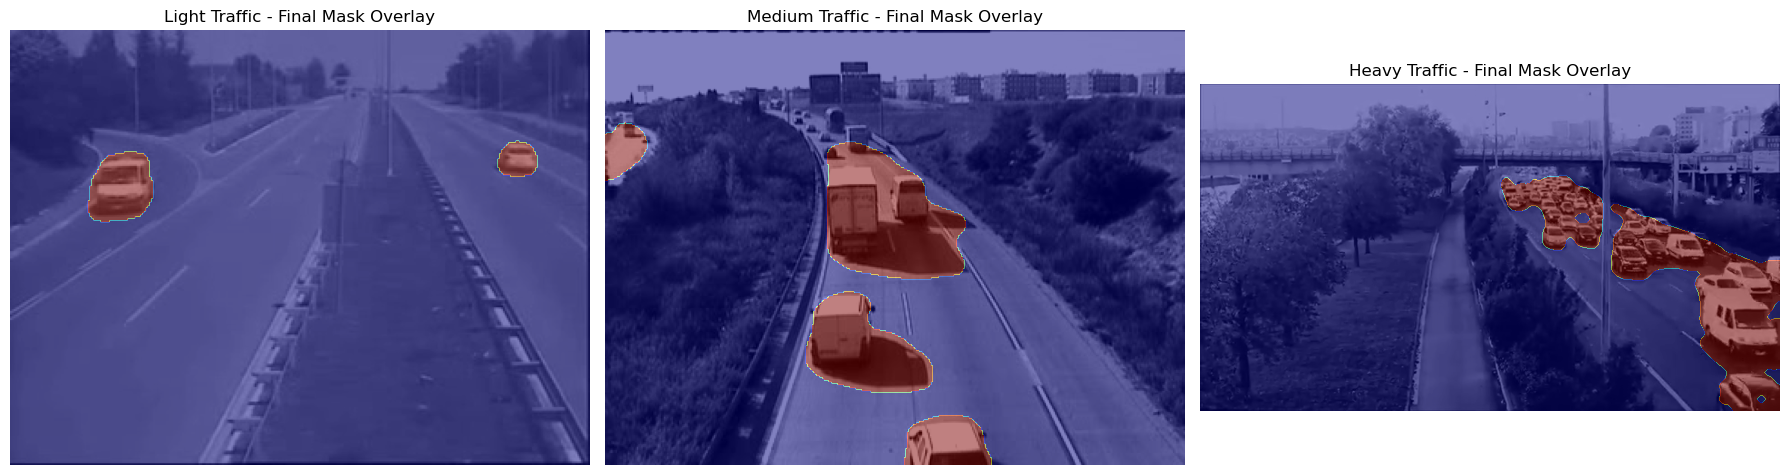

In [174]:
# Define the parameters for each video's car mask computation.
mask_params = {
    "Light Traffic": {"diff_threshold": 15, "blur_kernel": 23, "morph_open_iter": 1, "morph_close_iter": 3, "morph_kernel_size": 15},
    "Medium Traffic": {"diff_threshold": 41, "blur_kernel": 31, "morph_open_iter": 1, "morph_close_iter": 1, "morph_kernel_size": 15},
    "Heavy Traffic": {"diff_threshold": 31, "blur_kernel": 29, "morph_open_iter": 3, "morph_close_iter": 3, "morph_kernel_size": 3},
}

# Map each video title to its corresponding frames, average background and road mask.
videos_info = [
    ("Light Traffic", light_gray_frames, average_background_light, mask_light),
    ("Medium Traffic", medium_gray_frames, average_background_medium, mask_medium),
    ("Heavy Traffic", heavy_gray_frames, average_background_heavy, mask_heavy)
]

final_masks = {}
last_frames = {}

for title, frames, background, road_mask in videos_info:
    print(f"Processing {title} video...")
    final_mask = None
    last_frame = None
    # Process all frames and update final_mask with the mask computed on the latest frame.
    for frame in frames:
        p = mask_params[title]
        car_mask = extract_cars(frame, background, road_mask,
                                diff_threshold=p["diff_threshold"],
                                blur_kernel=p["blur_kernel"],
                                morph_open_iter=p["morph_open_iter"],
                                morph_close_iter=p["morph_close_iter"],
                                morph_kernel_size=p["morph_kernel_size"])
        final_mask = car_mask
        last_frame = frame
        
        # Isolate the car regions from the grayscale frame
        cars_extracted = cv.bitwise_and(frame, frame, mask=car_mask)
        
        # Display the video windows
        cv.imshow(f"{title} - Cars Isolated", cars_extracted)
        cv.imshow(f"{title} - Original Video", frame)
        
        if cv.waitKey(30) in [ESC_KEY, Q_KEY]:
            break
    cv.destroyAllWindows()

    final_masks[title] = final_mask
    last_frames[title] = last_frame
# Plot the three overlays below the cell.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, title in zip(axes, ["Light Traffic", "Medium Traffic", "Heavy Traffic"]):
    # Display the last grayscale frame
    ax.imshow(last_frames[title], cmap='gray')
    # Overlay the final mask on top with some transparency
    ax.imshow(final_masks[title], cmap='jet', alpha=0.5)
    ax.set_title(f"{title} - Final Mask Overlay")
    ax.axis('off')
plt.tight_layout()
plt.show()

The car detection process is working quite well, as it accurately identifies the moving cars in the video frames. However, we can see that the process is not perfect, as it sometimes fails to detect cars that are partially obscured or moving quickly. Also, the process is including the shadows of the cars as moving objects, which can lead to false positives in the car count. 

It's important to note that applying the mask to all of the road area may not be the best approach since we could only use the road area where cars are the closest to the camera. This would help us avoid detecting cars that are far away and reduce the number of false positives in the car count.